In [ ]:
"""
!git clone -b EMT https://github.com/pop756/Quantum_KAN.git
%cd Quantum_KAN
!pip install -r requirements.txt"""

In [1]:
import pennylane as qml
from pennylane import numpy as np
import random





def ising_model_circuit(num_qubits=4,num_layer = 2,single='X',double='ZZ',J=0.25,h=0.125):
    """
    Creates a parameterized quantum circuit for simulating the Ising model
    with specified number of qubits and layers. The circuit includes random 
    interaction strengths and external field strengths.
    
    Args:
    num_qubits (int): Number of qubits in the circuit.
    num_layer (int): Number of layers of Ising interactions and external field terms.
    
    Returns:
    cost (function): The cost function which returns the expected value of the PauliZ observable on the first qubit.
    """
        
    # Define the device
    dev = qml.device("default.mixed", wires=num_qubits)
    
    # Define random interaction strengths and external field strengths
    J = np.array(list([J])*num_qubits)
    h = np.array(list([h])*num_qubits)

    def circuit(params):
        # Apply RX rotations with parameters
        for i in range(num_qubits):
            qml.RX(params[i], wires=i)
        for j in range(num_layer):
            # Apply Ising ZZ interactions
            for i in range(num_qubits - 1):
                getattr(qml,f"Ising{double}")(2 * J[i], wires=[i, i+1])

            
            # Apply external field X terms
            for i in range(num_qubits):
                getattr(qml,f"R{single}")(2 * h[i], wires=i)

    # Define the Ising model Hamiltonian
    coeffs = []
    obs = []

    @qml.qnode(dev,interface='torch')
    def cost(params):
        circuit(params)
        return qml.expval(qml.Identity(0))
    
    return cost

# Example usage
num_parameters = 4  # One parameter per qubit for RX rotations
params = list(np.random.uniform(0, 2 * np.pi, num_parameters))
random_circuit = ising_model_circuit(4,2,single='Y',double='ZZ',J=0.25,h=0.125)
train_circuit = ising_model_circuit(4,2,single='Y',double='ZZ',J=0.,h=0.)

print(random_circuit(params))
print(qml.draw(random_circuit)(params))


0.9999999999999989
0: ──RX(1.97)─╭IsingZZ(0.50)──RY(0.25)─────────────────────╭IsingZZ(0.50)──RY(0.25)─────
1: ──RX(5.21)─╰IsingZZ(0.50)─╭IsingZZ(0.50)──RY(0.25)──────╰IsingZZ(0.50)─╭IsingZZ(0.50)
2: ──RX(0.57)────────────────╰IsingZZ(0.50)─╭IsingZZ(0.50)──RY(0.25)──────╰IsingZZ(0.50)
3: ──RX(4.84)───────────────────────────────╰IsingZZ(0.50)──RY(0.25)────────────────────

───────────────────────────┤  <I>
───RY(0.25)────────────────┤     
──╭IsingZZ(0.50)──RY(0.25)─┤     
──╰IsingZZ(0.50)──RY(0.25)─┤     


In [2]:
meas1 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])
meas2 = qml.Hamiltonian([1,1,1,1], [qml.PauliZ(0),qml.PauliZ(1),qml.PauliZ(2),qml.PauliZ(3)])

In [3]:

from functions.Error_mitigation import extra_polation,extra_polation_time
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import pennylane as qml


# 데이터셋 생성 클래스
class QuantumData_time(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 3, 5],size=50):
        """
        QuantumData_time 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            if _ ==  0:
                theta = [0]*para_num
            else:
                theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation_time(circuit, meas, theta, noise_factor=input_list, p1=0.1, p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# 데이터셋 생성 클래스
class QuantumData_gate(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 1.2, 1.4],size=50):
        """
        QuantumData_gate 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation(circuit, meas, theta, noise_factor=input_list, p1=0.05, p2=0.05)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

"""
input_list1 = [0,0.25,0.5,0.75,9]
input_list2 = [1,1.5,2,2.5,3]
# 데이터셋 및 데이터 로더 생성
dataset_temp = QuantumData_time(random_circuit,meas1,input_list1,size=50)
dataset = QuantumData_time(random_circuit,meas1,input_list2,size=50)
train_size = int(0.8 * len(dataset))   
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=15, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)"""

'\ninput_list1 = [0,0.25,0.5,0.75,9]\ninput_list2 = [1,1.5,2,2.5,3]\n# 데이터셋 및 데이터 로더 생성\ndataset_temp = QuantumData_time(random_circuit,meas1,input_list1,size=50)\ndataset = QuantumData_time(random_circuit,meas1,input_list2,size=50)\ntrain_size = int(0.8 * len(dataset))   \nval_size = len(dataset) - train_size\ntrain_dataset, val_dataset = random_split(dataset, [train_size, val_size])\n\n# 데이터 로더\ntrain_loader = DataLoader(dataset, batch_size=15, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)'

In [4]:
from functions.Error_mitigation import extra_polation,extra_polation_time
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
from torch.utils.data import random_split, DataLoader
import pennylane as qml


# 데이터셋 생성 클래스
class QuantumData_time(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 3, 5],size=50):
        """
        QuantumData_time 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            if _ ==  0:
                theta = [0]*para_num
            else:
                theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation_time(circuit, meas, theta, noise_factor=input_list, p1=0.1, p2=0.1)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# 데이터셋 생성 클래스
class QuantumData_gate(Dataset):
    def __init__(self,circuit,meas,input_list = [1, 1.2, 1.4],size=50):
        """
        QuantumData_gate 클래스는 특정 양자 회로와 측정에 기반하여 데이터를 생성합니다.
        주어진 크기(size)만큼의 데이터를 생성하며, 각 데이터는 일정한 노이즈 요인 하에서
        양자 회로의 결과를 포함합니다.
        
        Args:
        size (int): 생성할 데이터의 수
        """
        np.random.seed(42)
        para_num = len(circuit.device.wires)
        self.data = []
        self.labels = []
        for _ in tqdm(range(size)):
            # 0에서 2π 사이의 랜덤 theta 값 6개 생성
            theta = [np.random.uniform(0, 2 * np.pi) for i in range(para_num)]
            # random_circuit 및 meas1 함수와 theta 값을 사용하여 노이즈 팩터와 결과 생성
            noise_factor, result = extra_polation(circuit, meas, theta, noise_factor=input_list, p1=0.05, p2=0.05)
            self.data.append(np.array(noise_factor))
            self.labels.append(result)
    
    def __len__(self):
        """
        데이터셋의 크기 반환
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
        주어진 인덱스에 해당하는 데이터 및 레이블 반환
        
        Args:
        idx (int): 인덱스
        
        Returns:
        tuple: 데이터 (torch.tensor)와 레이블 (torch.tensor)
        """
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


input_list1 = [0,0.25,0.5,0.75,9]
input_list2 = [1,1.5,2,2.5,3]
# 데이터셋 및 데이터 로더 생성
train_dataset = QuantumData_time(train_circuit,meas1,input_list2,size=50)
val_dataset = QuantumData_time(random_circuit,meas1,input_list2,size=50)
val_dataset_temp = QuantumData_time(random_circuit,meas1,input_list1,size=50)
# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)

  0%|          | 0/50 [00:00<?, ?it/s]

c:\Users\pop75\anaconda3\envs\Lee\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
  8%|▊         | 4/50 [00:13<02:39,  3.46s/it]


KeyboardInterrupt: 

In [ ]:
"""
import pickle as pkl
pkl_data = {}
pkl_data['circuit'] = qml.draw(random_circuit)(params)
pkl_data['data'] = dataset,input_list2
pkl_data['inform'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"

with open('./data/Quantum_data_2.pkl','wb') as file:
    pkl.dump(pkl_data,file)
"""

'\nimport pickle as pkl\npkl_data = {}\npkl_data[\'circuit\'] = qml.draw(random_circuit)(params)\npkl_data[\'data\'] = dataset,input_list2\npkl_data[\'inform\'] = "p1=0.01,p2=0.01 로 구성되어 있고 서킷에 노이즈를 가한 결과, parameter : 초기 x gate 4개"\n\nwith open(\'./data/Quantum_data_2.pkl\',\'wb\') as file:\n    pkl.dump(pkl_data,file)\n'

In [25]:
"""
# 데이터셋 및 데이터 로더 생성

train_size = int(0.3 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# 데이터 로더
train_loader = DataLoader(dataset, batch_size=500, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)"""

'\n# 데이터셋 및 데이터 로더 생성\n\ntrain_size = int(0.3 * len(dataset))\nval_size = len(dataset) - train_size\ntrain_dataset, val_dataset = random_split(dataset, [train_size, val_size])\n\n# 데이터 로더\ntrain_loader = DataLoader(dataset, batch_size=500, shuffle=True)\nval_loader = DataLoader(val_dataset, batch_size=500, shuffle=False)'

In [26]:
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(len(input_list2), 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.GELU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return torch.squeeze(self.fc3(x))

model_MLP = RegressionModel()
criterion = nn.MSELoss()
optimizer_MLP = torch.optim.Adam(model_MLP.parameters(), lr=0.01)

from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([len(input_list2),1,1],grid=5)
    def forward(self, x):
        output = self.KAN(x)
        #output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output
    
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.unsqueeze(x,2)
        h0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 은닉 상태 초기화
        c0 = torch.zeros(1, x.size(0), self.hidden_size)  # LSTM의 초기 셀 상태 초기화
        out, _ = self.lstm(x, (h0, c0))  # LSTM을 통해 시퀀스 처리
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력을 fully connected layer에 적용하여 출력 생성
        return out

model = Model()
LSTM_model = LSTMModel(1, 32, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer_LSTM = torch.optim.Adam(LSTM_model.parameters(), lr=0.05)

In [27]:
from functions.training import Early_stop_train,Early_stop_train_KAN,accuracy

In [28]:
#from functions.training import Early_stop_train_KAN

train_seq_KAN = Early_stop_train_KAN(model,optimizer,criterion)

train_seq_KAN.train_model(train_loader,val_loader,res=10)

C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



Test set: Average loss: 1.4892, Accuracy: 0.0/50 (0%)
Epoch 1 Loss 1.841900 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 1.2336, Accuracy: 0.0/50 (0%)
Epoch 2 Loss 1.532075 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 1.0083, Accuracy: 0.0/50 (0%)
Epoch 3 Loss 1.249749 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.8394, Accuracy: 0.0/50 (0%)
Epoch 4 Loss 1.025789 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.7162, Accuracy: 0.0/50 (0%)
Epoch 5 Loss 0.861077 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.6352, Accuracy: 0.0/50 (0%)
Epoch 6 Loss 0.750417 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.5974, Accuracy: 0.0/50 (0%)
Epoch 7 Loss 0.701062 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.5767, Accuracy: 0.0/50 (0%)
Epoch 8 Loss 0.675150 acc : 0.000000 reg : 0.000000 stop count : 0
Test set: Average loss: 0.5511,

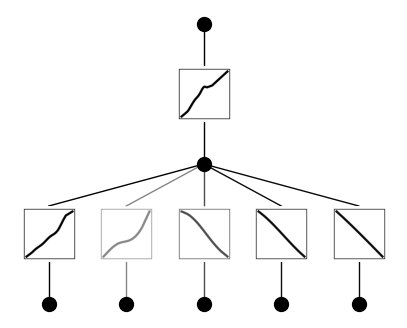

In [29]:
model.KAN.plot(beta=15)

In [30]:
model.KAN.auto_symbolic()

fixing (0,0,0) with arctan, r2=0.9898313283920288
fixing (0,1,0) with tan, r2=0.9849224090576172
fixing (0,2,0) with sin, r2=0.9999528527259827
fixing (0,3,0) with sin, r2=0.9999968409538269
fixing (0,4,0) with x^2, r2=0.9999889731407166
fixing (1,0,0) with arctan, r2=0.9859511256217957


In [31]:
model.KAN.symbolic_formula()

([3.73*atan(-2.49*(-0.53*x_5 - 1)**2 - 0.16*sin(3.02*x_3 + 6.01) + 0.52*sin(3.28*x_4 + 3.0) + 0.08*tan(1.51*x_2 - 6.25) + 11.02*atan(0.38*x_1 - 1.4) + 13.02) - 0.66],
 [x_1, x_2, x_3, x_4, x_5])

In [32]:
#from functions.training import Early_stop_train

train_seq = Early_stop_train(model_MLP,optimizer_MLP,criterion)
train_seq.train_model(train_loader,val_loader)

C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



Test set: Average loss: 1.7397, Accuracy: 0.0/50 (0%)
Epoch 1 Loss 2.167299 acc : 0.000000 stop count : 0
Test set: Average loss: 1.6002, Accuracy: 0.0/50 (0%)
Epoch 2 Loss 1.993448 acc : 0.000000 stop count : 0
Test set: Average loss: 1.4682, Accuracy: 0.0/50 (0%)
Epoch 3 Loss 1.827830 acc : 0.000000 stop count : 0
Test set: Average loss: 1.3281, Accuracy: 0.0/50 (0%)
Epoch 4 Loss 1.651027 acc : 0.000000 stop count : 0
Test set: Average loss: 1.1717, Accuracy: 0.0/50 (0%)
Epoch 5 Loss 1.452586 acc : 0.000000 stop count : 0
Test set: Average loss: 0.9968, Accuracy: 0.0/50 (0%)
Epoch 6 Loss 1.229781 acc : 0.000000 stop count : 0
Test set: Average loss: 0.8091, Accuracy: 0.0/50 (0%)
Epoch 7 Loss 0.989220 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6234, Accuracy: 0.0/50 (0%)
Epoch 8 Loss 0.749020 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4651, Accuracy: 0.0/50 (0%)
Epoch 9 Loss 0.540746 acc : 0.000000 stop count : 0
Test set: Average loss: 0.3665, Accuracy: 0.0

In [33]:

train_seq_LSTM = Early_stop_train(LSTM_model,optimizer_LSTM,criterion)
train_seq_LSTM.train_model(train_loader,val_loader)


Test set: Average loss: 1.6692, Accuracy: 0.0/50 (0%)
Epoch 1 Loss 2.082975 acc : 0.000000 stop count : 0
Test set: Average loss: 1.6143, Accuracy: 0.0/50 (0%)
Epoch 2 Loss 1.984389 acc : 0.000000 stop count : 0
Test set: Average loss: 1.3929, Accuracy: 0.0/50 (0%)
Epoch 3 Loss 1.723161 acc : 0.000000 stop count : 0
Test set: Average loss: 0.6664, Accuracy: 0.0/50 (0%)
Epoch 4 Loss 0.820317 acc : 0.000000 stop count : 0
Test set: Average loss: 1.0614, Accuracy: 0.0/50 (0%)
Epoch 5 Loss 1.053264 acc : 0.000000 stop count : 1
Test set: Average loss: 1.2228, Accuracy: 0.0/50 (0%)
Epoch 6 Loss 1.086659 acc : 0.000000 stop count : 2

C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



Test set: Average loss: 0.6908, Accuracy: 0.0/50 (0%)
Epoch 7 Loss 0.673861 acc : 0.000000 stop count : 3
Test set: Average loss: 0.3927, Accuracy: 0.0/50 (0%)
Epoch 8 Loss 0.485443 acc : 0.000000 stop count : 0
Test set: Average loss: 0.4821, Accuracy: 0.0/50 (0%)
Epoch 9 Loss 0.592905 acc : 0.000000 stop count : 1
Test set: Average loss: 0.5837, Accuracy: 0.0/50 (0%)
Epoch 10 Loss 0.699232 acc : 0.000000 stop count : 2
Test set: Average loss: 0.5984, Accuracy: 0.0/50 (0%)
Epoch 11 Loss 0.717993 acc : 0.000000 stop count : 3
Test set: Average loss: 0.5462, Accuracy: 0.0/50 (0%)
Epoch 12 Loss 0.666243 acc : 0.000000 stop count : 4
Test set: Average loss: 0.4690, Accuracy: 0.0/50 (0%)
Epoch 13 Loss 0.583200 acc : 0.000000 stop count : 5
Test set: Average loss: 0.4090, Accuracy: 0.0/50 (0%)
Epoch 14 Loss 0.507033 acc : 0.000000 stop count : 6
Test set: Average loss: 0.3975, Accuracy: 0.0/50 (0%)
Epoch 15 Loss 0.466368 acc : 0.000000 stop count : 7
Test set: Average loss: 0.4374, Accurac

In [34]:
from functions.Error_mitigation import extrapolate_values
from scipy.optimize import curve_fit
# 선형 함수 정의
def linear_func(x, a, b):
    return a * x + b

# 지수 함수 정의
def exp_func(x, a, b, c):
    return b*a **(x) + c

def extrapolate_values_temp(y_data,x_data,label):
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x_data, y_data)
    a_linear, b_linear = params_linear
    y_linear_0 = linear_func(0, a_linear, b_linear)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -5, -np.inf], [1, 5, np.inf])

    params_exp, _ = curve_fit(exp_func, x_data, y_data, p0=initial_guess, bounds=bounds, maxfev=10000)
    a_exp, b_exp, c_exp = params_exp
    y_exp_0 = exp_func(0, a_exp, b_exp, c_exp)

    if -0.4<label<0.4:
        return y_data[0],params_linear
    else:
        return y_exp_0,params_exp
        

y_lin_list = []
y_exp_list = []
y_temp_list = []
y_list = []
x_list = []


for x,y in tqdm(val_dataset):
    y_linear_0, y_exp_0,_,_= extrapolate_values(x,x_data=input_list2)
    y_res,_ = extrapolate_values_temp(x,x_data=input_list2,label=y)
    y_lin_list.append(y_linear_0)
    y_exp_list.append(y_exp_0)
    y_temp_list.append(y_res)
    y_list.append(y)
    x_list.append(float(x[0]))

x_list,y_lin_list,y_exp_list ,y_list = torch.tensor(x_list),torch.tensor(y_lin_list).float(),torch.tensor(y_exp_list).float(),torch.tensor(y_list).float()

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
100%|██████████| 50/50 [00:03<00:00, 16.58it/s]


In [35]:
y_temp_list= torch.tensor(y_temp_list).float()
Lin_loss = torch.nn.MSELoss()(y_lin_list,y_list).item()
exp_loss = torch.nn.MSELoss()(y_exp_list,y_list).item()
raw_loss = torch.nn.MSELoss()(x_list,y_list).item()
temp_loss = torch.nn.MSELoss()(y_temp_list,y_list).item()


In [36]:
temp_loss,raw_loss,exp_loss,Lin_loss

(0.8149058818817139,
 0.7051026225090027,
 0.8193463683128357,
 0.4917835295200348)

In [37]:
for x,y in val_loader:
    x

C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)


In [38]:
LSTM_output = torch.squeeze(LSTM_model(x))
KAN_output = torch.squeeze(model(x))
MLP_output = torch.squeeze(model_MLP(x))

MLP_loss = torch.nn.MSELoss()(MLP_output,y_list).item()
KAN_loss = torch.nn.MSELoss()(KAN_output,y_list).item()
LSTM_loss = torch.nn.MSELoss()(LSTM_output,y_list).item()


In [39]:
loss_list = {'lin':Lin_loss,'exp':exp_loss,'raw':raw_loss,'MLP':MLP_loss,'KAN':KAN_loss,'LSTM':LSTM_loss}

for name,loss in loss_list.items():
    print(f"{name} = {loss}")

lin = 0.4917835295200348
exp = 0.8193463683128357
raw = 0.7051026225090027
MLP = 0.0207468643784523
KAN = 0.06283850222826004
LSTM = 0.3927115499973297


In [40]:
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
def curve_plot(x,y):
    # 선형 함수 정의
    def linear_func(x, a, b):
        return a * x + b

    # 지수 함수 정의
    def exp_func(x, a, b, c):
        return b*a **(x) + c
    
    # 선형 함수 피팅
    params_linear, _ = curve_fit(linear_func, x, y)

    # 지수 함수 피팅 초기 추정값 및 범위 설정
    initial_guess = [0.8, 1, 1]
    bounds = ([0, -5, -np.inf], [1, 5, np.inf])

    params_exp, _ = curve_fit(exp_func, x, y, p0=initial_guess, bounds=bounds, maxfev=10000)
    
    # 맞춘 함수 플롯
    x_fit = np.linspace(0, max(x), 100)
    y_fit_linear = linear_func(x_fit, *params_linear)
    y_fit_exp = exp_func(x_fit, *params_exp)
    
    
    plt.plot(x_fit, y_fit_linear, label='Linear fitted function')
    plt.plot(x_fit, y_fit_exp , label='Exp fitted function')

C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\4088630284.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)
C:\Users\pop75\AppData\Local\Temp\ipykernel_1652\211835907.py:40: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot([0],output[index-1],'bo',color=colors[index2],label=f'{models[index2]} predict')


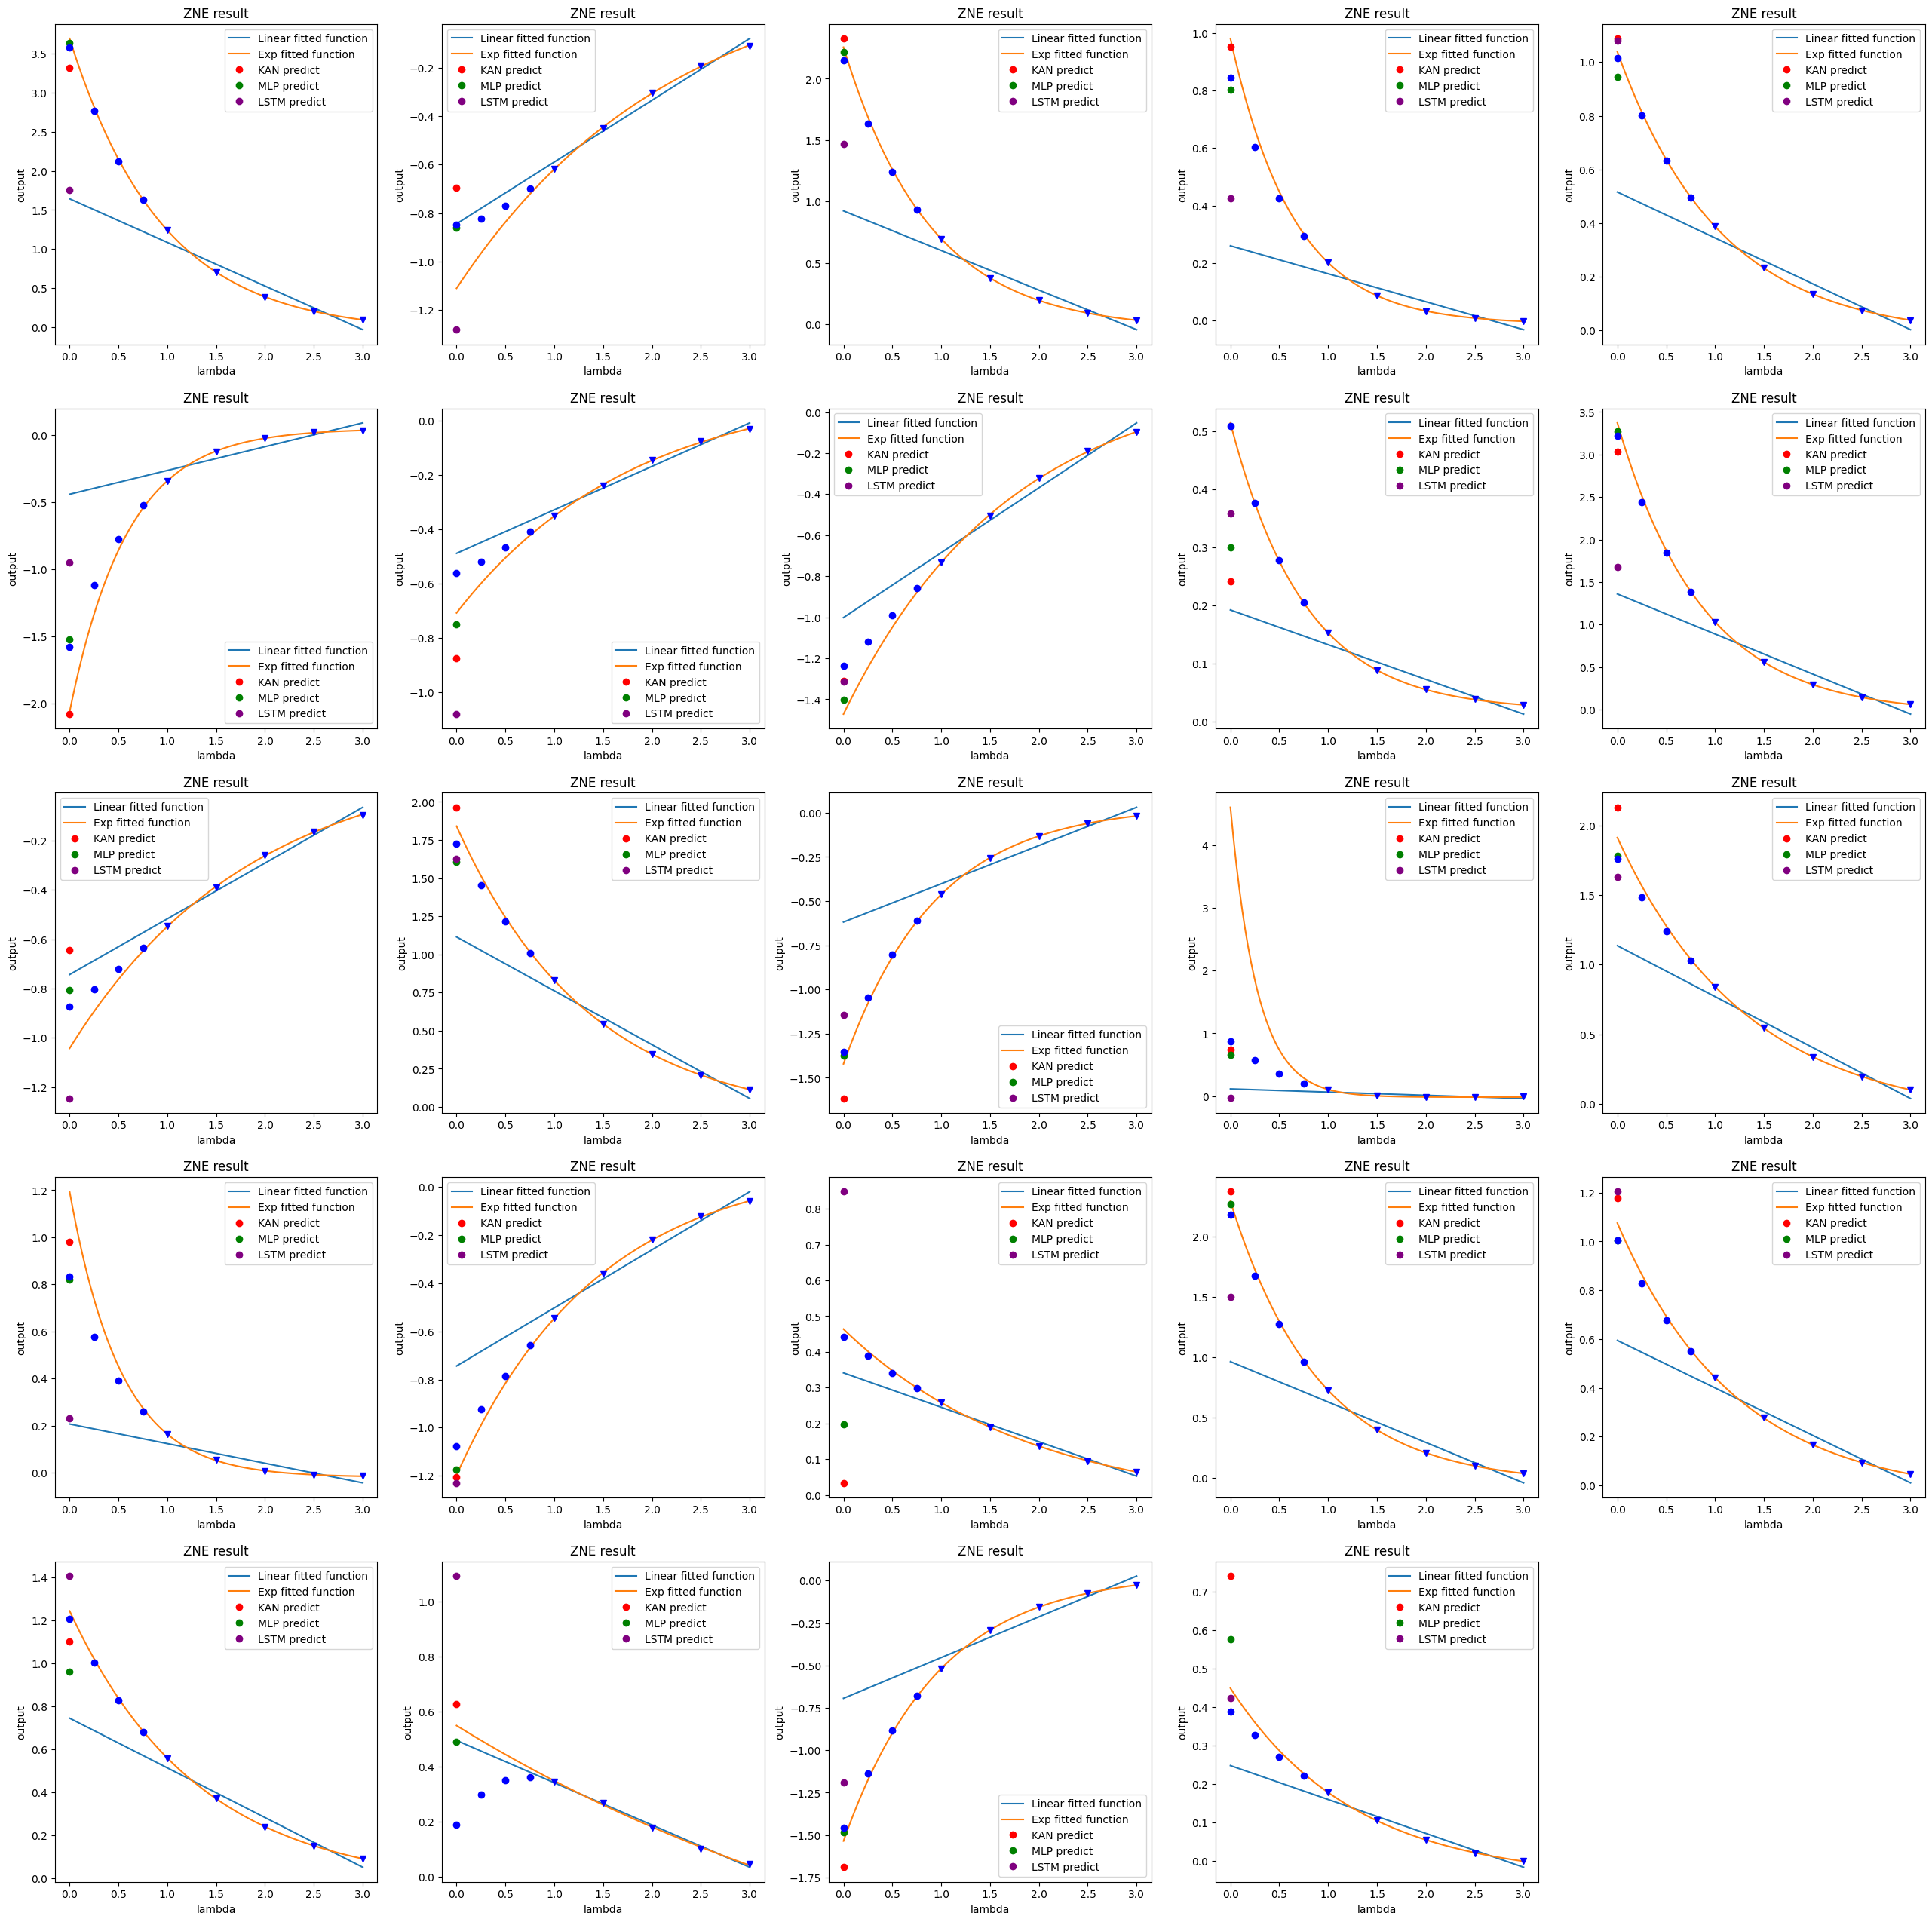

In [41]:
from matplotlib import pyplot as plt
plt.figure(figsize=(32,32))
index = 1
x_tensor = None
y_tensor = None
for (x,y),(x1,y1) in zip(val_dataset,val_dataset_temp):
    
    y = torch.unsqueeze(y,dim=0)
    if x_tensor is None:
        x_len = len(x)
        x_tensor = x
        y_tensor = y
    else:
        x_tensor = torch.concat([x_tensor,x],dim=0)
        y_tensor = torch.concat([y_tensor,y],dim=0)
x_tensor = torch.reshape(x_tensor,[-1,len(x)])
y_tensor = torch.reshape(y_tensor,[-1,1])

output_KAN = model(x_tensor).detach().numpy()
output_MLP = model_MLP(x_tensor).detach().numpy()
output_LSTM = LSTM_model(x_tensor).detach().numpy()

model_outputs = [output_KAN,output_MLP,output_LSTM]
colors = ['red','green','purple']
models = ['KAN','MLP','LSTM']

for (x,y),(x1,y1) in zip(val_dataset,val_dataset_temp):
    if index <25:
        
        
        
        
        plt.subplot(5,5,index)
        plt.title("ZNE result")
        plt.xlabel("lambda")
        plt.ylabel("output")
        curve_plot(input_list2,x)
        
        for index2,output in enumerate(model_outputs):
            plt.plot([0],output[index-1],'bo',color=colors[index2],label=f'{models[index2]} predict')
        
        
        plt.plot(input_list1[:4],list(x1[:4]),'bo')
        plt.plot(input_list2,list(x),'bv')
        
    
        plt.legend()
        index+=1
    else:
        break

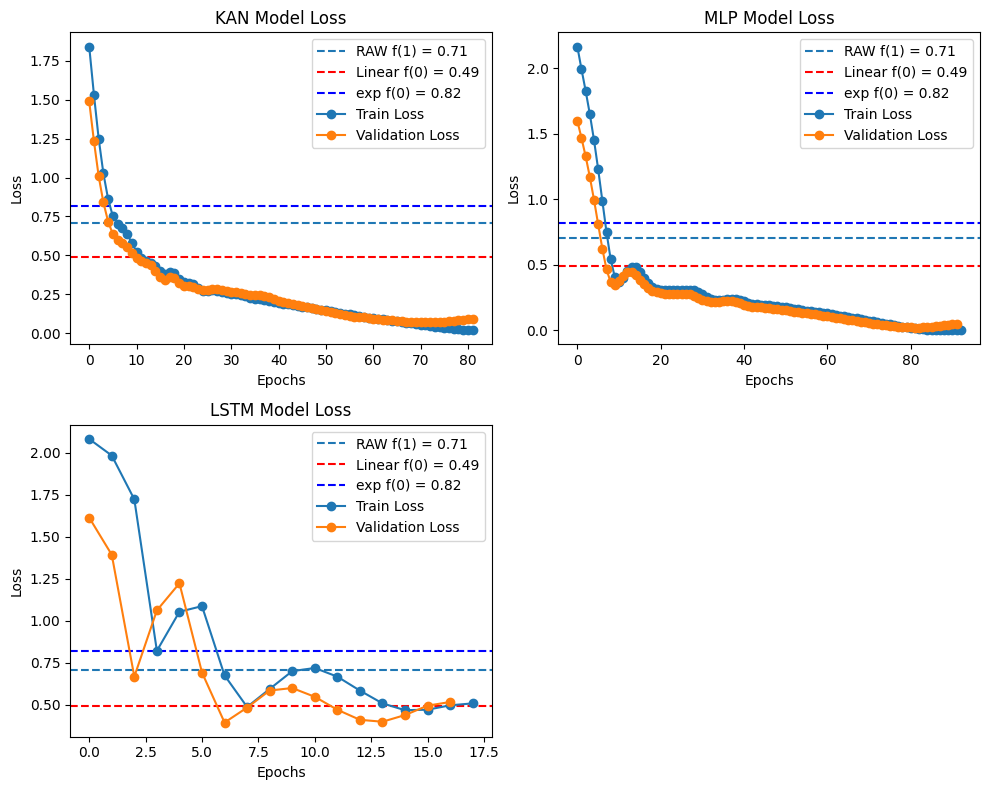

In [42]:
import matplotlib.pyplot as plt



# 예시 데이터
KAN_model_train_loss = train_seq_KAN.train_loss_list
KAN_model_val_loss = train_seq_KAN.loss_list
MLP_model_train_loss = train_seq.train_loss_list
MLP_model_val_loss = train_seq.loss_list
LSTM_model_train_loss = train_seq_LSTM.train_loss_list
LSTM_model_val_loss = train_seq_LSTM.loss_list







# KAN 모델 Loss 플롯
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")

plt.plot(KAN_model_train_loss, label='Train Loss', marker='o')
plt.plot(KAN_model_val_loss, label='Validation Loss', marker='o')
plt.title('KAN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 2)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(MLP_model_train_loss, label='Train Loss', marker='o')
plt.plot(MLP_model_val_loss, label='Validation Loss', marker='o')
plt.title('MLP Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# MLP 모델 Loss 플롯
plt.subplot(2, 2, 3)
# RAW loss
plt.axhline(y=raw_loss, linestyle='--', label=f"RAW f(1) = {raw_loss:.2f}")
# Lin loss
plt.axhline(y=Lin_loss, color = 'red',linestyle='--', label=f"Linear f(0) = {Lin_loss:.2f}")
# Exp loss
plt.axhline(y=exp_loss, color = 'blue',linestyle='--', label=f"exp f(0) = {exp_loss:.2f}")
plt.plot(LSTM_model_train_loss, label='Train Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='Validation Loss', marker='o')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


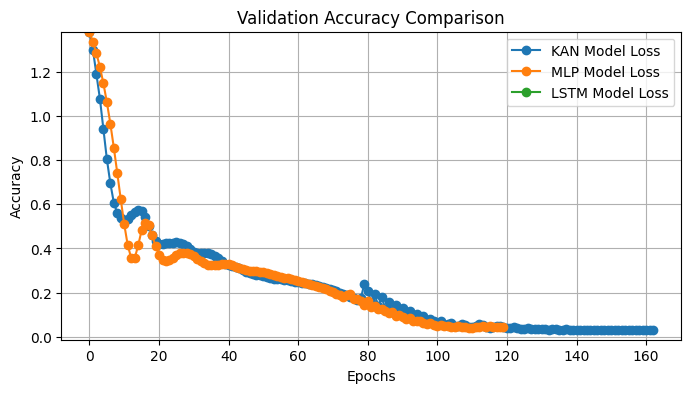

In [ ]:
import matplotlib.pyplot as plt

# Epochs
# 정확도 플롯
plt.figure(figsize=(8, 4))
plt.plot(KAN_model_val_loss, label='KAN Model Loss', marker='o')
plt.plot(MLP_model_val_loss, label='MLP Model Loss', marker='o')
plt.plot(LSTM_model_val_loss, label='LSTM Model Loss', marker='o')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.ylim(np.min(MLP_model_train_loss)-0.05,np.max(MLP_model_train_loss)+0.05)
plt.show()